In [57]:
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenSimpleFactory()
    g_energietraeger_factory = General.GEnergietraegerSimpleFactory()
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_klassen_factory, g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_pickle_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data_factory = Nutzenergieanalyse.NEADataETKlassenFactory(nea_data_pickle_factory)
    nea_data = nea_data_factory.create(g_data).data
    return {land.name: {sektor.name: {bereich.name: nea_data[land][sektor][bereich] for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

def create_eb_data(g_data: Domain.General.GData):
    eb_data_pickle_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_data_factory = Energiebilanz.EBDataETKlassenFactory(eb_data_pickle_factory)
    eb_data = eb_data_factory.create(g_data).data
    return {land.name: {sektor.name: eb_data[land][sektor] for sektor in eb_data[land].keys()} for land in eb_data.keys()}

def create_b_data(g_data: Domain.General.GData):
    b_data_factory = Bevoelkerung.BDataPickleFactory(pathlib.Path('Data/Serialization'), list(general_data.laender.values()))
    b_data = b_data_factory.create(list(general_data.laender.values())).data
    return {land.name: b_data[land] for land in b_data.keys()}
    
laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_data = create_nea_data(general_data)
eb_data = create_eb_data(general_data)
b_data = create_b_data(general_data)


In [58]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()


In [59]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)


In [72]:
nea_data['wien']['Wohngebäude'].keys()

dict_keys(['Heizen', 'Warmwasser und Kochen', 'Strom'])

In [87]:
def create_nea_sektor_sums(land: str, sektor: str):
    return pd.DataFrame([pd.Series(nea_data[land][sektor][bereich].sum(axis=1), name=bereich) for bereich in nea_data[land][sektor].keys()]).transpose()

def create_nea_bereich_extension(data, land: str, sektor: str, bereich: str):
    return (eb_data[land][sektor].transpose() * clean_negative_values(data[bereich])).transpose()['1988':'1992']

def extend_nea_data(land: str, sektor: str):
    relative = calc_relative(create_nea_sektor_sums(land, sektor))
    relative_ex = extrapolation_extension.run(relative, pd.PeriodIndex(pd.period_range(start='1988', end='2020', freq='A'), name=relative.index.name))
    return {sektor: pd.concat([create_nea_bereich_extension(relative_ex, land, sektor, bereich), nea_data[land][sektor][bereich]]) for bereich in nea_data[land][sektor].keys()}
    
#extend_nea_data('wien', 'Wohngebäude')

land = 'wien'
sektor = 'Wohngebäude'
bereich = 'Heizen'
relative = calc_relative(create_nea_sektor_sums(land, sektor))
relative_ex = extrapolation_extension.run(relative, pd.PeriodIndex(pd.period_range(start='1988', end='2020', freq='A'), name=relative.index.name))
nea_data['wien']['Wohngebäude']['Heizen']

list(pd.concat([create_nea_bereich_extension(relative_ex, land, sektor, bereich), nea_data[land][sektor][bereich]]) for bereich in nea_data[land][sektor].keys())
#create_nea_bereich_extension(relative_ex, land, sektor, bereich)
#pd.concat([create_nea_bereich_extension(relative_ex, land, sektor, bereich), nea_data[land][sektor][bereich]])
eb_data[land][sektor]
#nea_data[land][sektor][bereich]
relative

eb_data[land][sektor]
clean_negative_values(relative_ex[bereich])

eb_data[land][sektor]
nea_data[land][sektor][bereich]

,Fossile fest,Fossile flüssig,Fossile gasförmig,Brennbare Abfälle,Scheitholz,Biogene,Erneuerbare,Fernwärme,Elektrische Energie
1993,931.050432,2764.589412,14856.410463,0.0,609.970000,35.403116,20.577942,4395.207174,987.330547
1994,805.413024,2546.803925,16068.843334,0.0,642.550000,34.180958,24.609932,4311.592572,948.933584
1995,725.920416,2719.656238,15126.623483,0.0,771.060000,35.224939,27.407655,4940.632420,944.139399
1996,678.693132,3128.941292,12995.856476,0.0,980.115000,35.301557,30.236620,5819.035473,914.592867
1997,499.988081,2619.002486,15279.628317,0.0,1017.220000,36.900067,33.015574,5840.645841,832.115967
1998,434.212272,2557.568249,14041.385001,0.0,933.055000,36.892171,36.065680,5682.256445,833.872359
1999,389.482008,2563.654469,15904.411940,0.0,914.378121,29.561674,37.693055,5582.337247,864.301626
2000,380.530959,2254.092105,15066.946827,0.0,838.466278,37.537088,39.579367,5224.449989,831.046030
2001,393.572834,2543.747752,15510.650836,0.0,846.826564,83.720028,40.183653,5450.559839,908.283919
2002,404.550498,2804.235530,14925.390168,0.0,772.039298,99.279959,54.309233,5676.669690,904.754196


In [4]:
def run_scenario(df: pd.DataFrame, wanted: pd.Series):
    et = wanted.name
    
    df_relative = calc_relative(df)
    df_relative_without_et = df_relative.drop(et, axis=1)
    df_relative_without_et_relative = calc_relative(df_relative_without_et)
    
    to_sub = df[et] - wanted
    to_add = (df_relative_without_et_relative.transpose() * to_sub).transpose()
    to_add[et] = to_sub * -1

    result = df + to_add
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered
    
def run_scenarios(df: pd.DataFrame, wanted: pd.DataFrame):
    global_result = df.copy()
    for et in wanted.columns:
        local_result = run_scenario(global_result, wanted[et])
        global_result = local_result.drop(et, axis=1)
    result = pd.concat([global_result, wanted], axis=1)
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered
    

In [5]:
def create_linear_scenario(series: pd.Series, start: str, end: str, end_value):
    et = series.name
    index = series[start:end][1:].index
    start_value = series[start]
    decrement = start_value / (len(index))
    start_series = series[:start]
    wanted_series = pd.Series([start_value - decrement * (i + 1) for i in range(len(index))], index=index)
    end_series = series[end:][1:]
    result = pd.concat([start_series, wanted_series, end_series])
    result.name = series.name
    return result


### Generate result

per person

use moving average

interpolate population since some values are missing

In [6]:
def create_data_bereich(land: str, sektor: str, bereich: str):
    nea = nea_data[land][sektor][bereich]
    bevoelkerung = b_data[land]
    bevoelkerung = pd.Series(bevoelkerung, pd.period_range('1993', '2040', freq='A')).interpolate()
    nea_pp = (nea.transpose() / bevoelkerung['1993':'2020']).transpose().rolling(3).sum()['1995':]
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1995':]).transpose()

def create_data_sektor(land: str, sektor: str):
    return sum([create_data_bereich(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land(land: str):
    return sum([create_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich():
    return sum([create_data_land(land.name) for land in general_data.laender.values()])


### Test Szenario:

2040 -> 0 gas

2035 -> 0 oel

2030 -> 0 kohle

na: scheitholz bleibt gleich

na: fernwaerme, strom, umweltwaereme -> 1,2,3% steigung

In [7]:
def create_test_scenario(df):
    test_scenario_gas = create_linear_scenario(df['Fossile gasförmig'], '2020', '2040', 0)

    test_scenario_oel = create_linear_scenario(df['Fossile flüssig'], '2020', '2035', 0)
    test_scenario_oel = create_linear_scenario(test_scenario_oel, '2035', '2040', 0)

    test_scenario_kohle = create_linear_scenario(df['Fossile fest'], '2020', '2030', 0)
    test_scenario_kohle = create_linear_scenario(test_scenario_kohle, '2030', '2040', 0)

    #test_scenario_fernwaerme = create_limit_scenario(heizen_ph_wien_ex['Fernwärme'], '2020', 1.01)

    return pd.concat([test_scenario_gas, test_scenario_oel, test_scenario_kohle], axis=1)

In [8]:
def since_epoch(period):
        return (period - pd.Period('1970-01-01', freq=period.freq)).n

def plot_result(data, scenario):
    matplotlib.rcParams["figure.figsize"] = (20,20)
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['text.color'] = 'k'

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    data.plot(ax=ax1)
    ax1.set_title('Data')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('TJ')
    ax1.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

    scenario.plot(ax=ax2)
    ax2.set_title('Szenario')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('TJ')
    ax2.axvspan(since_epoch(scenario['2020':].index[0]), since_epoch(scenario.index[-1:][0]), color='#808080', alpha=0.2)

    fig.autofmt_xdate()
    plt.tight_layout()

    plt.show()

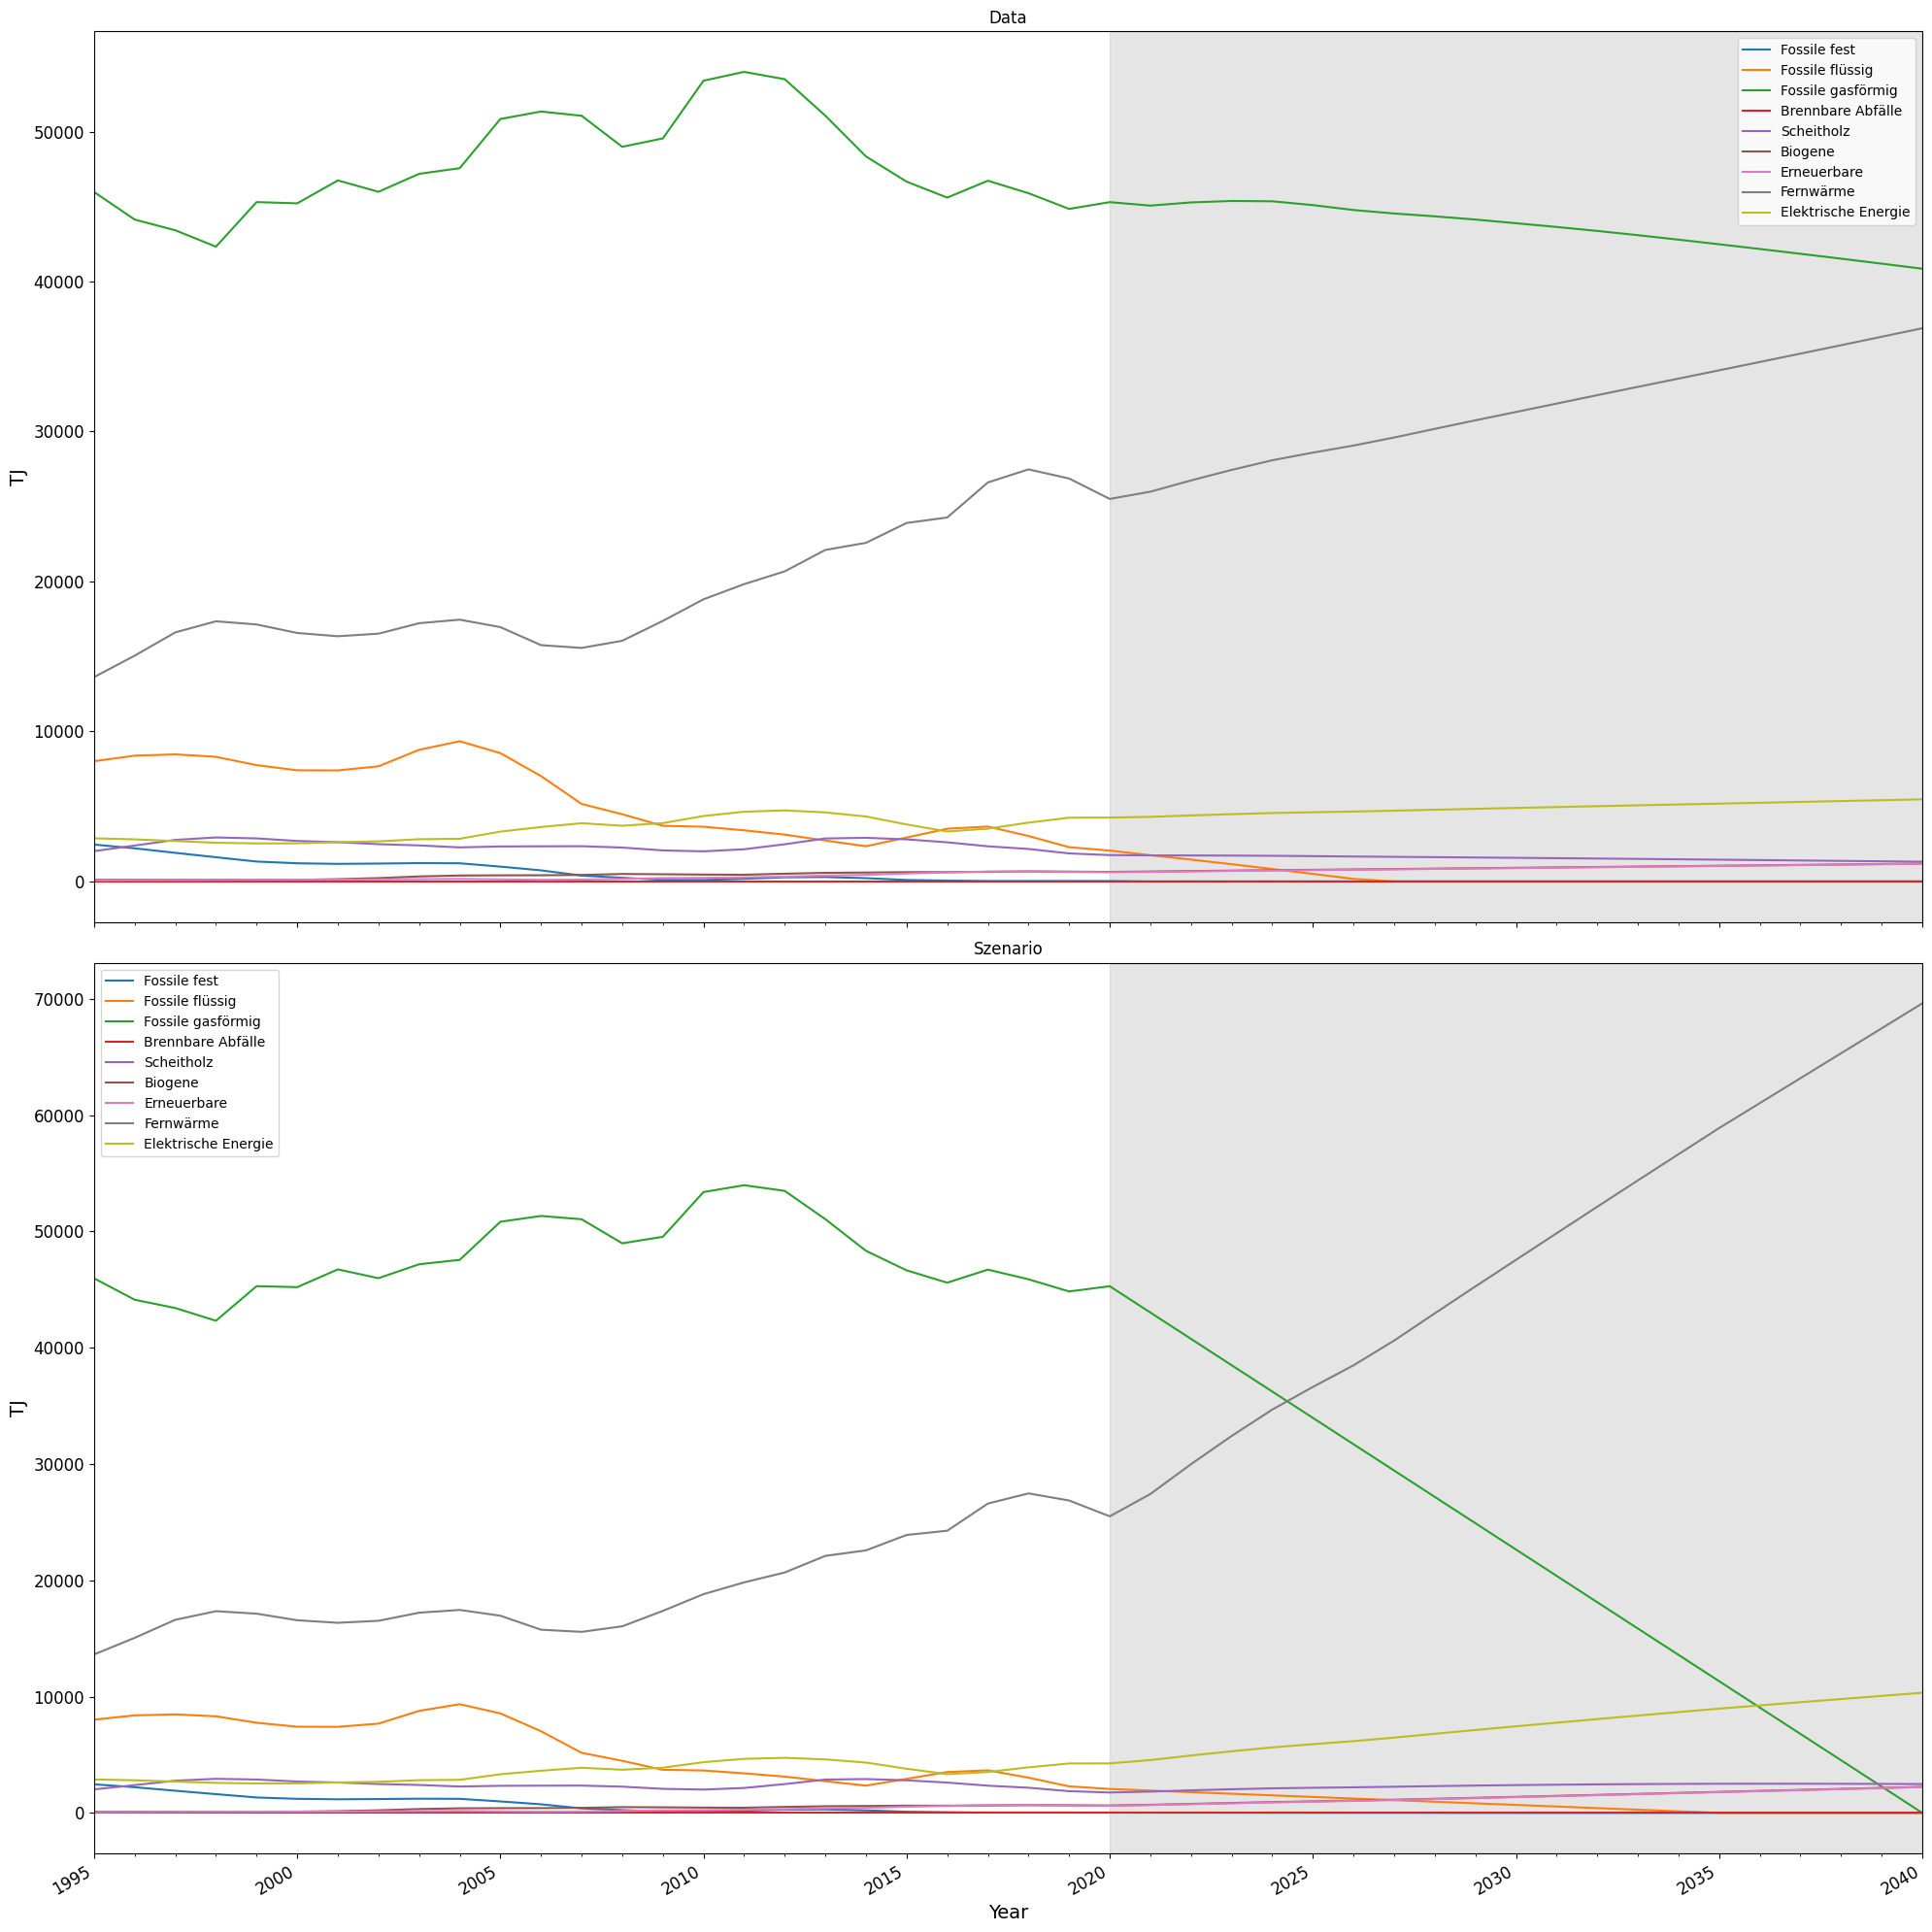

In [9]:
heizen_ph_wien = create_data_bereich('wien', 'Wohngebäude', 'Heizen')

test_scenario_heizen_ph_wien = create_test_scenario(heizen_ph_wien)
test_scenario_heizen_ph_wien_result = run_scenarios(heizen_ph_wien, test_scenario_heizen_ph_wien)

plot_result(heizen_ph_wien, test_scenario_heizen_ph_wien_result)

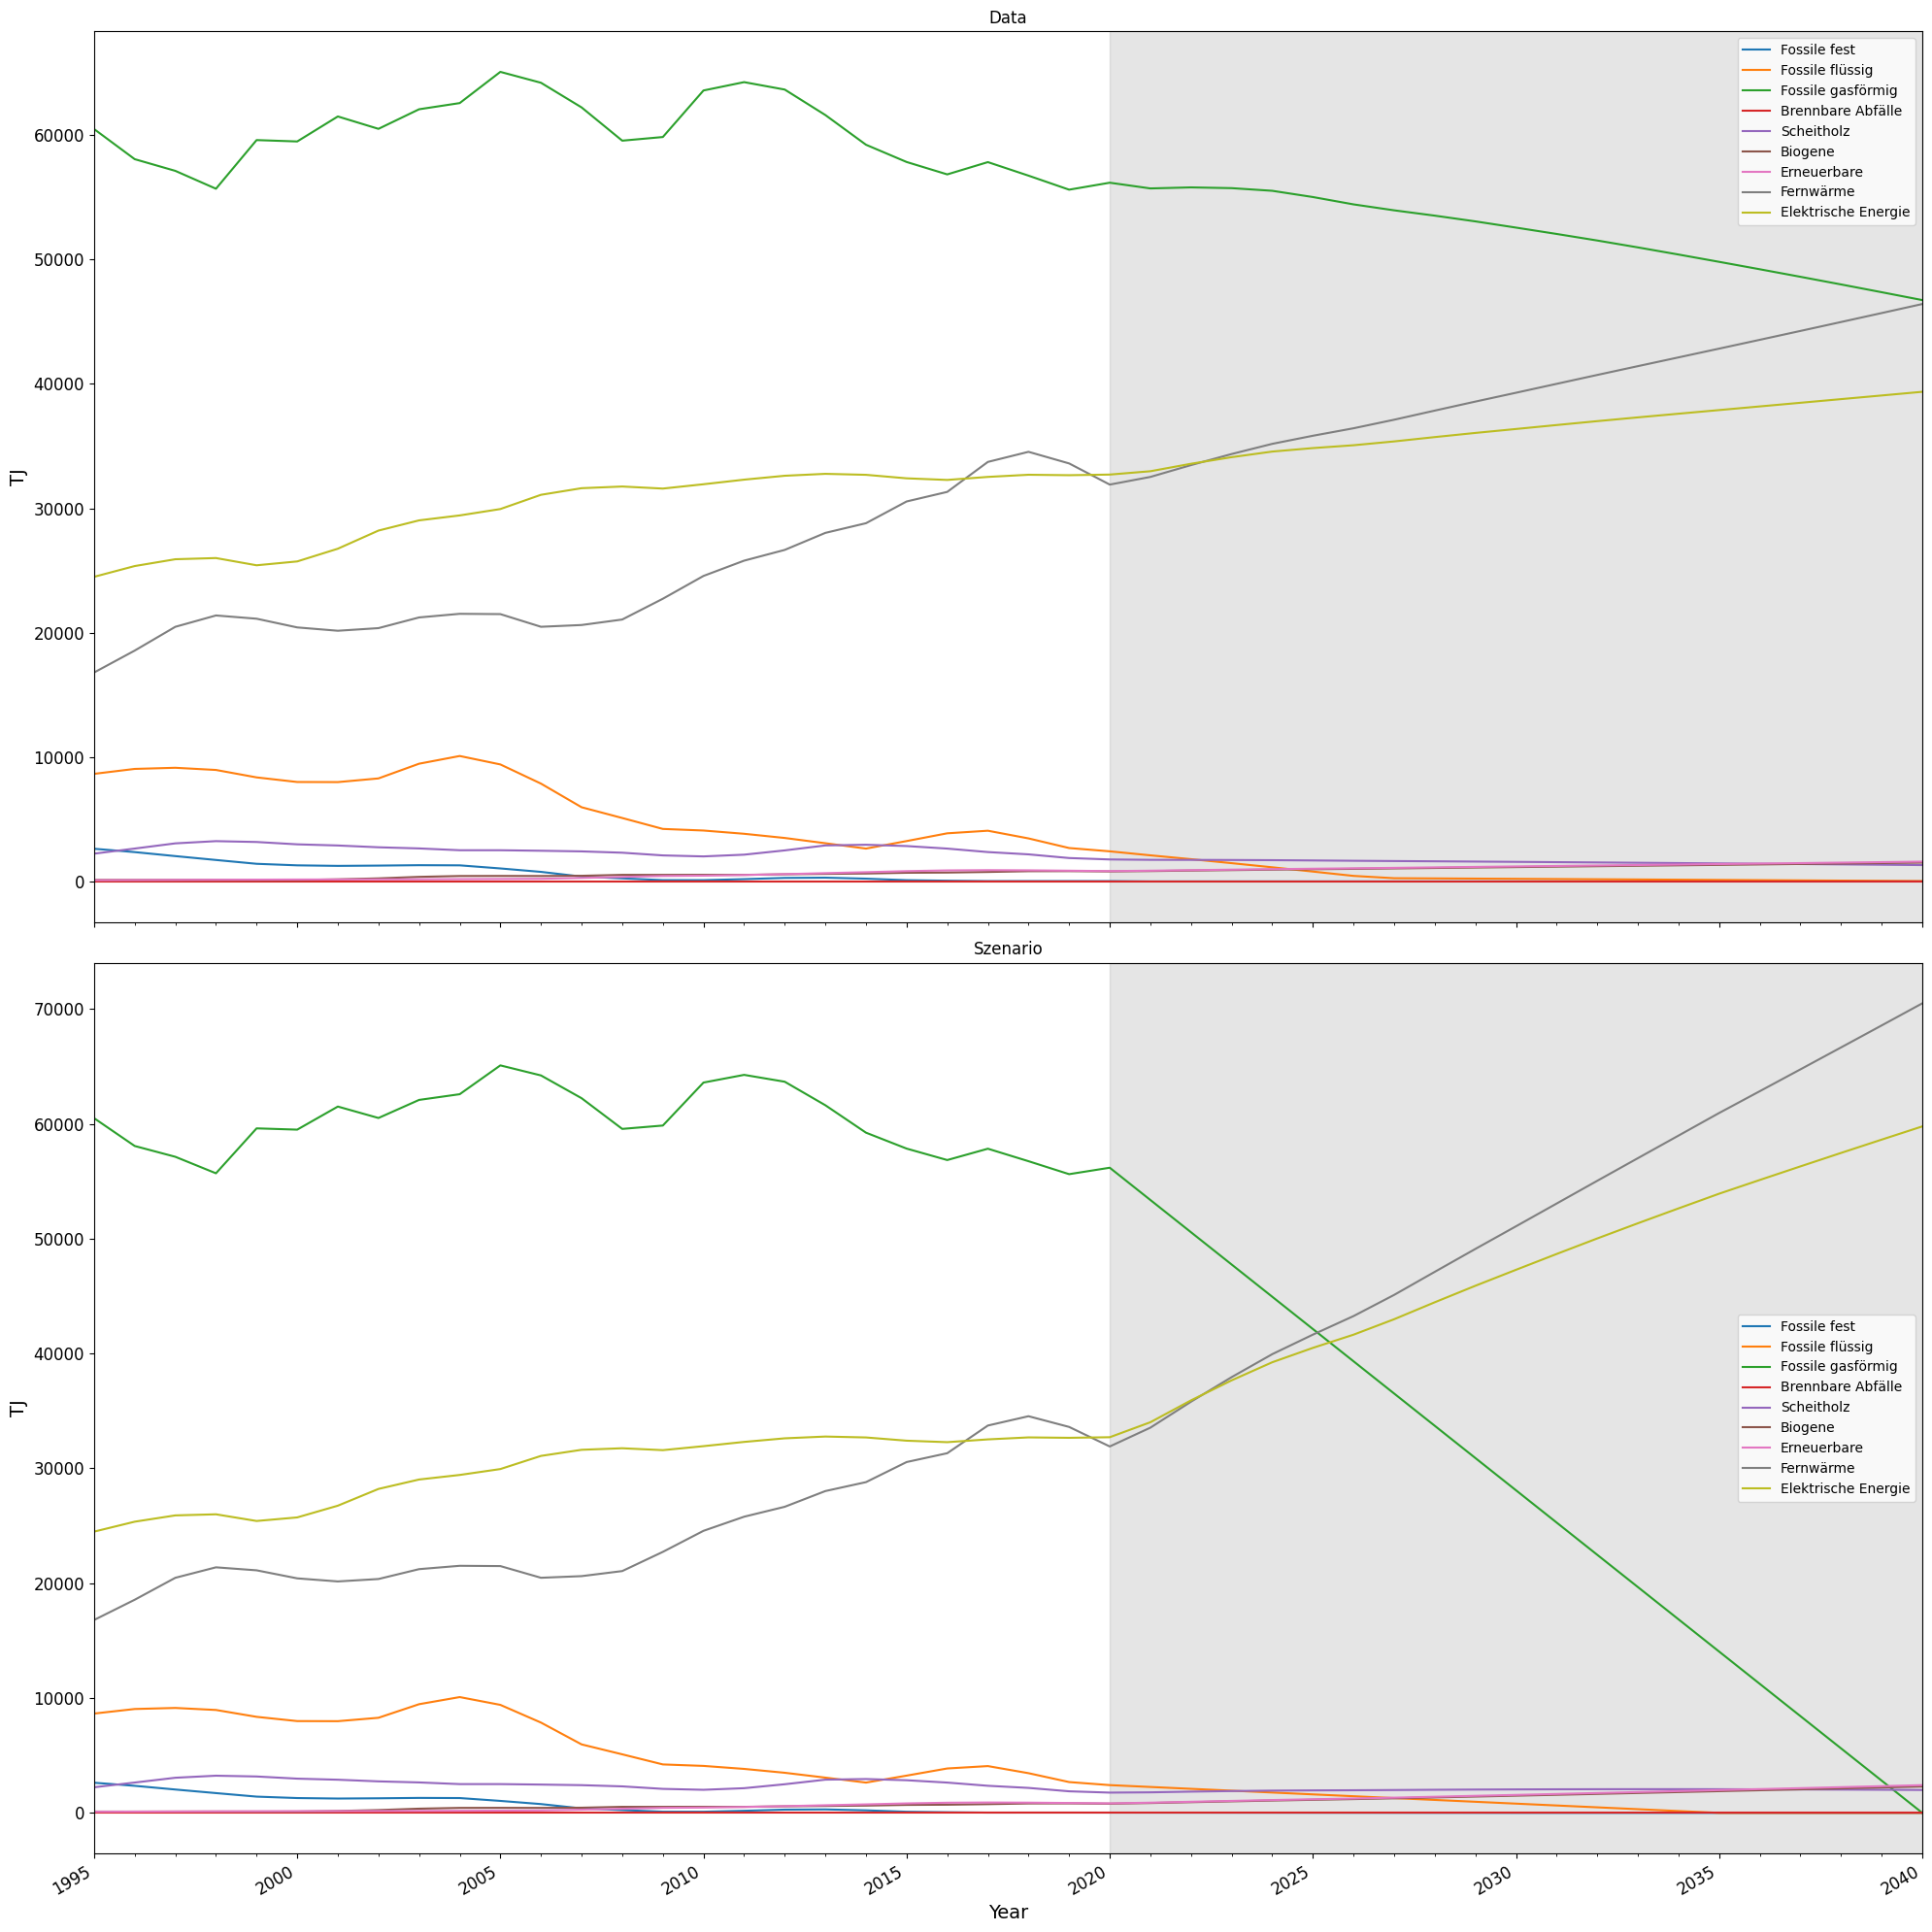

In [10]:
ph_wien = create_data_sektor('wien', 'Wohngebäude')

test_scenario_ph_wien = create_test_scenario(ph_wien)
test_scenario_ph_wien_result = run_scenarios(ph_wien, test_scenario_ph_wien)

plot_result(ph_wien, test_scenario_ph_wien_result)


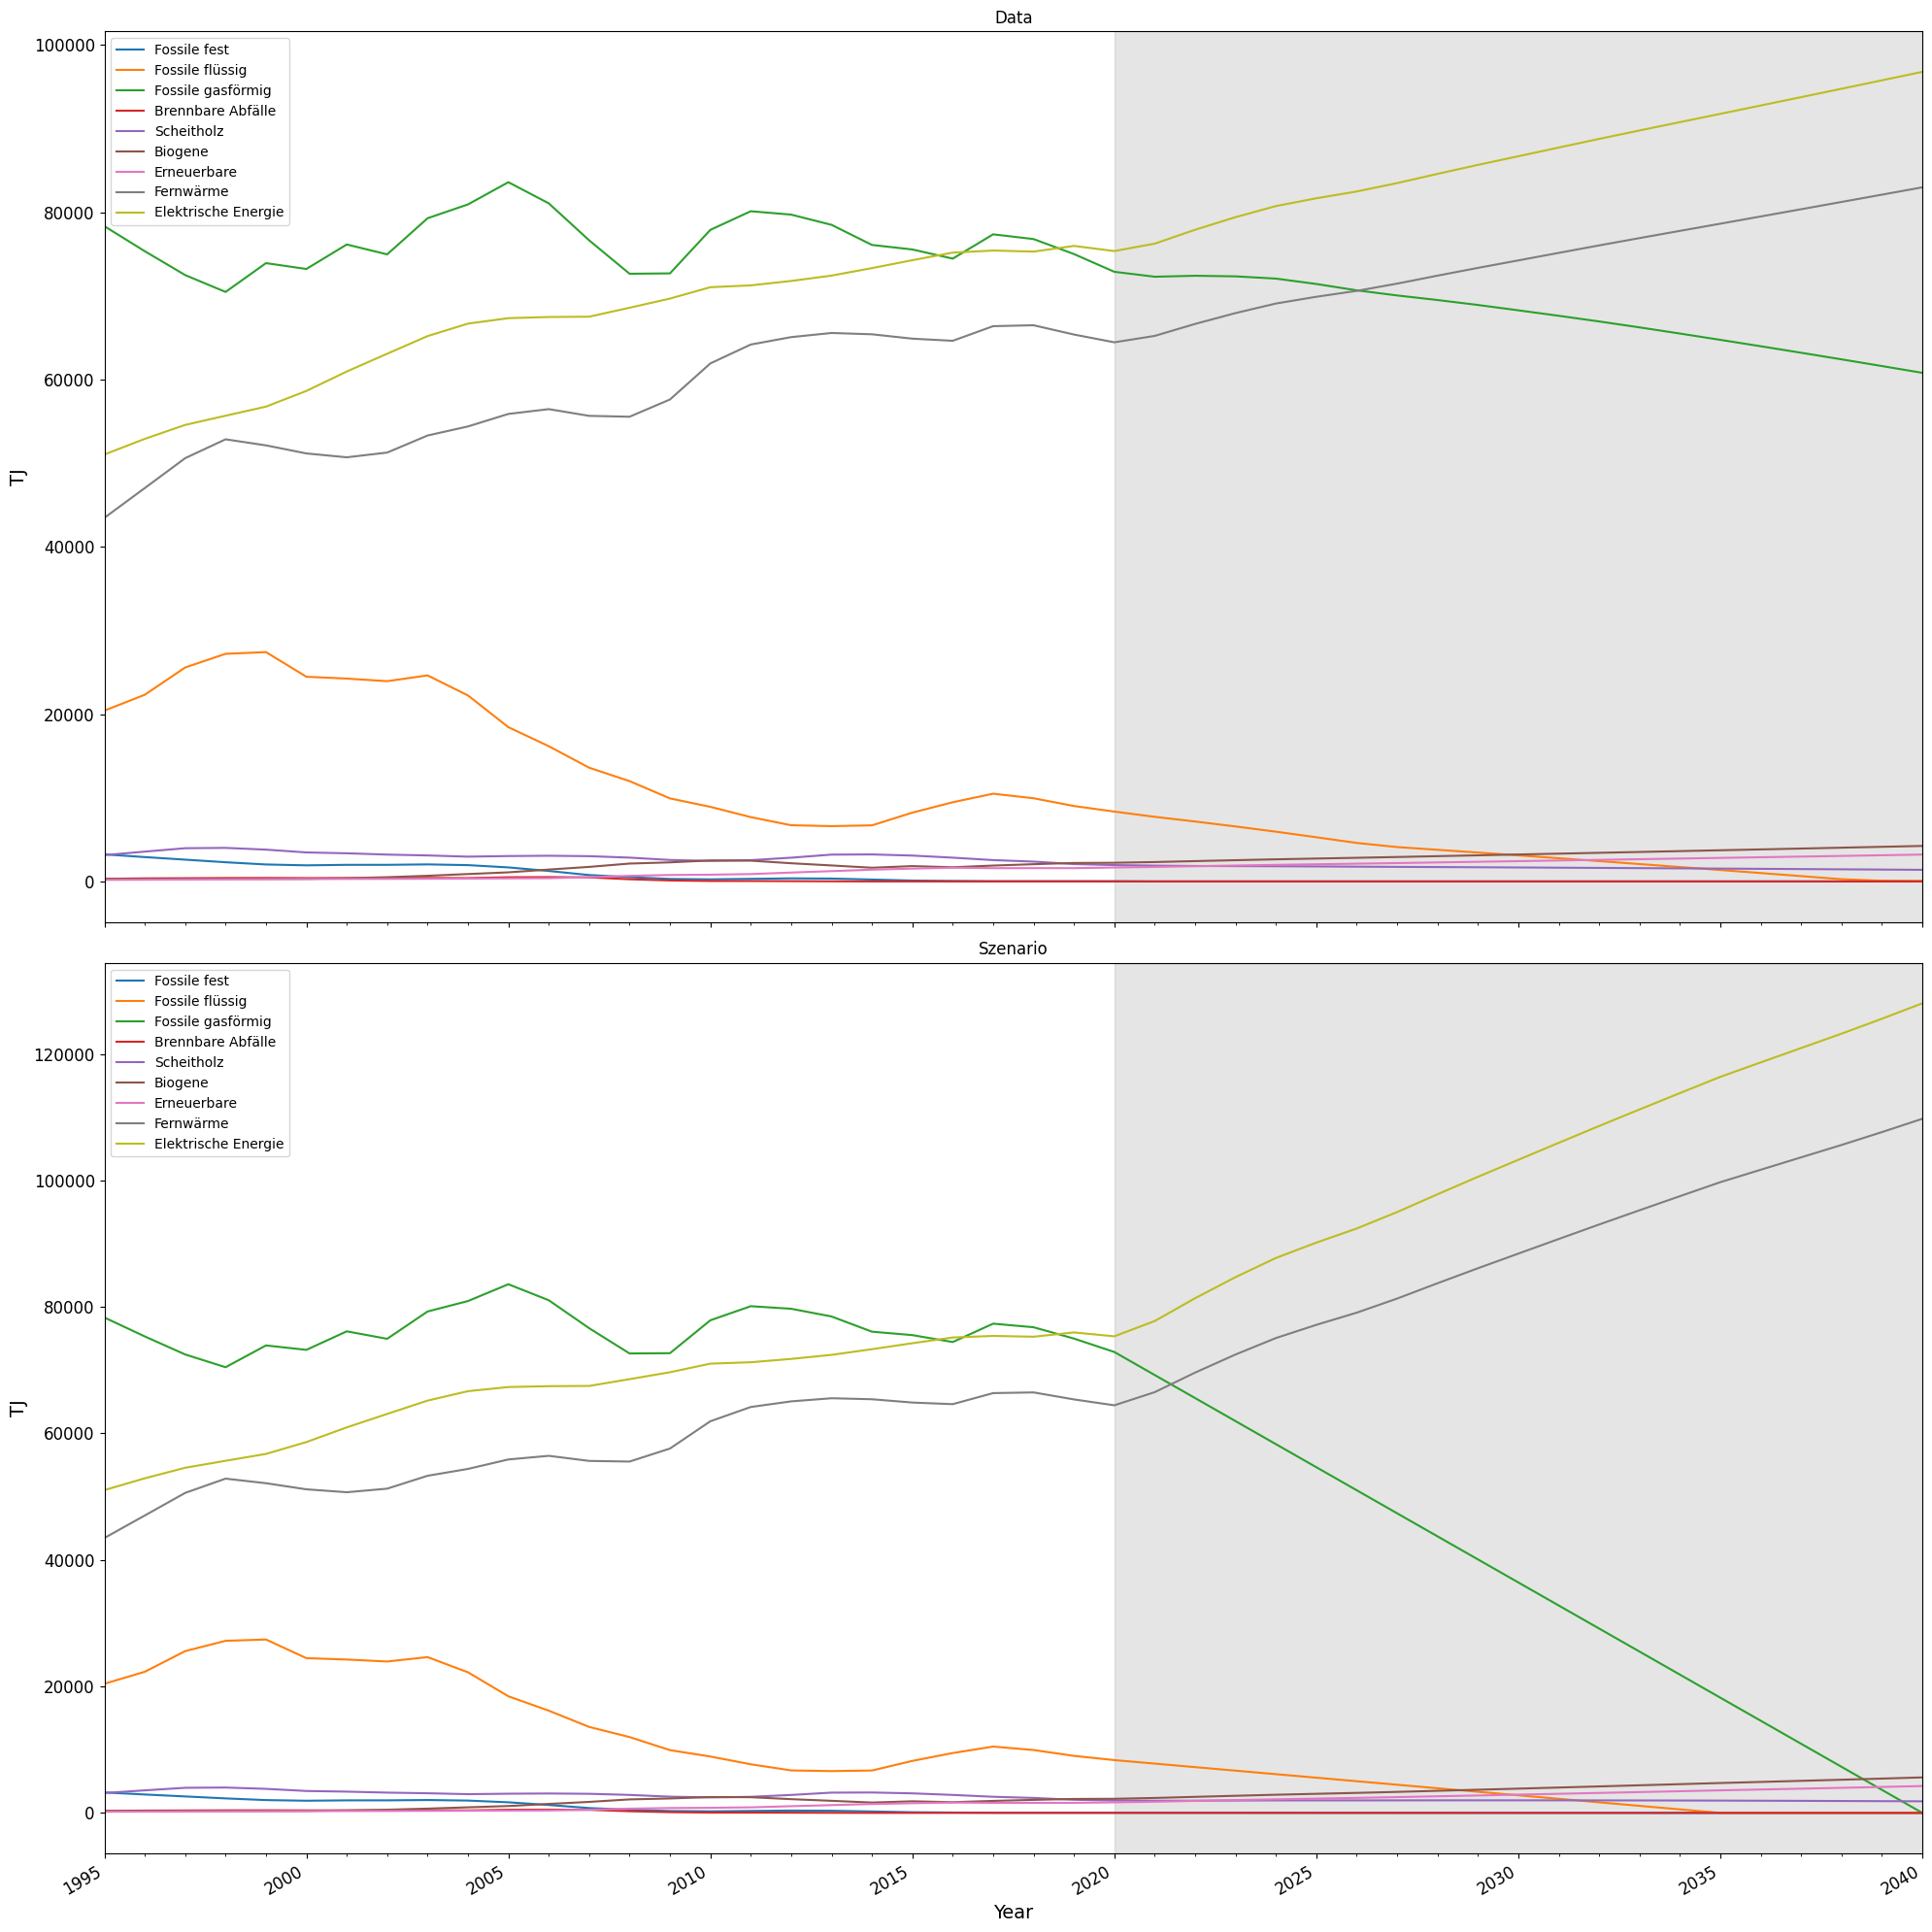

In [11]:
wien = create_data_land('wien')

test_scenario_wien = create_test_scenario(wien)
test_scenario_wien_result = run_scenarios(wien, test_scenario_wien)

plot_result(wien, test_scenario_wien_result)


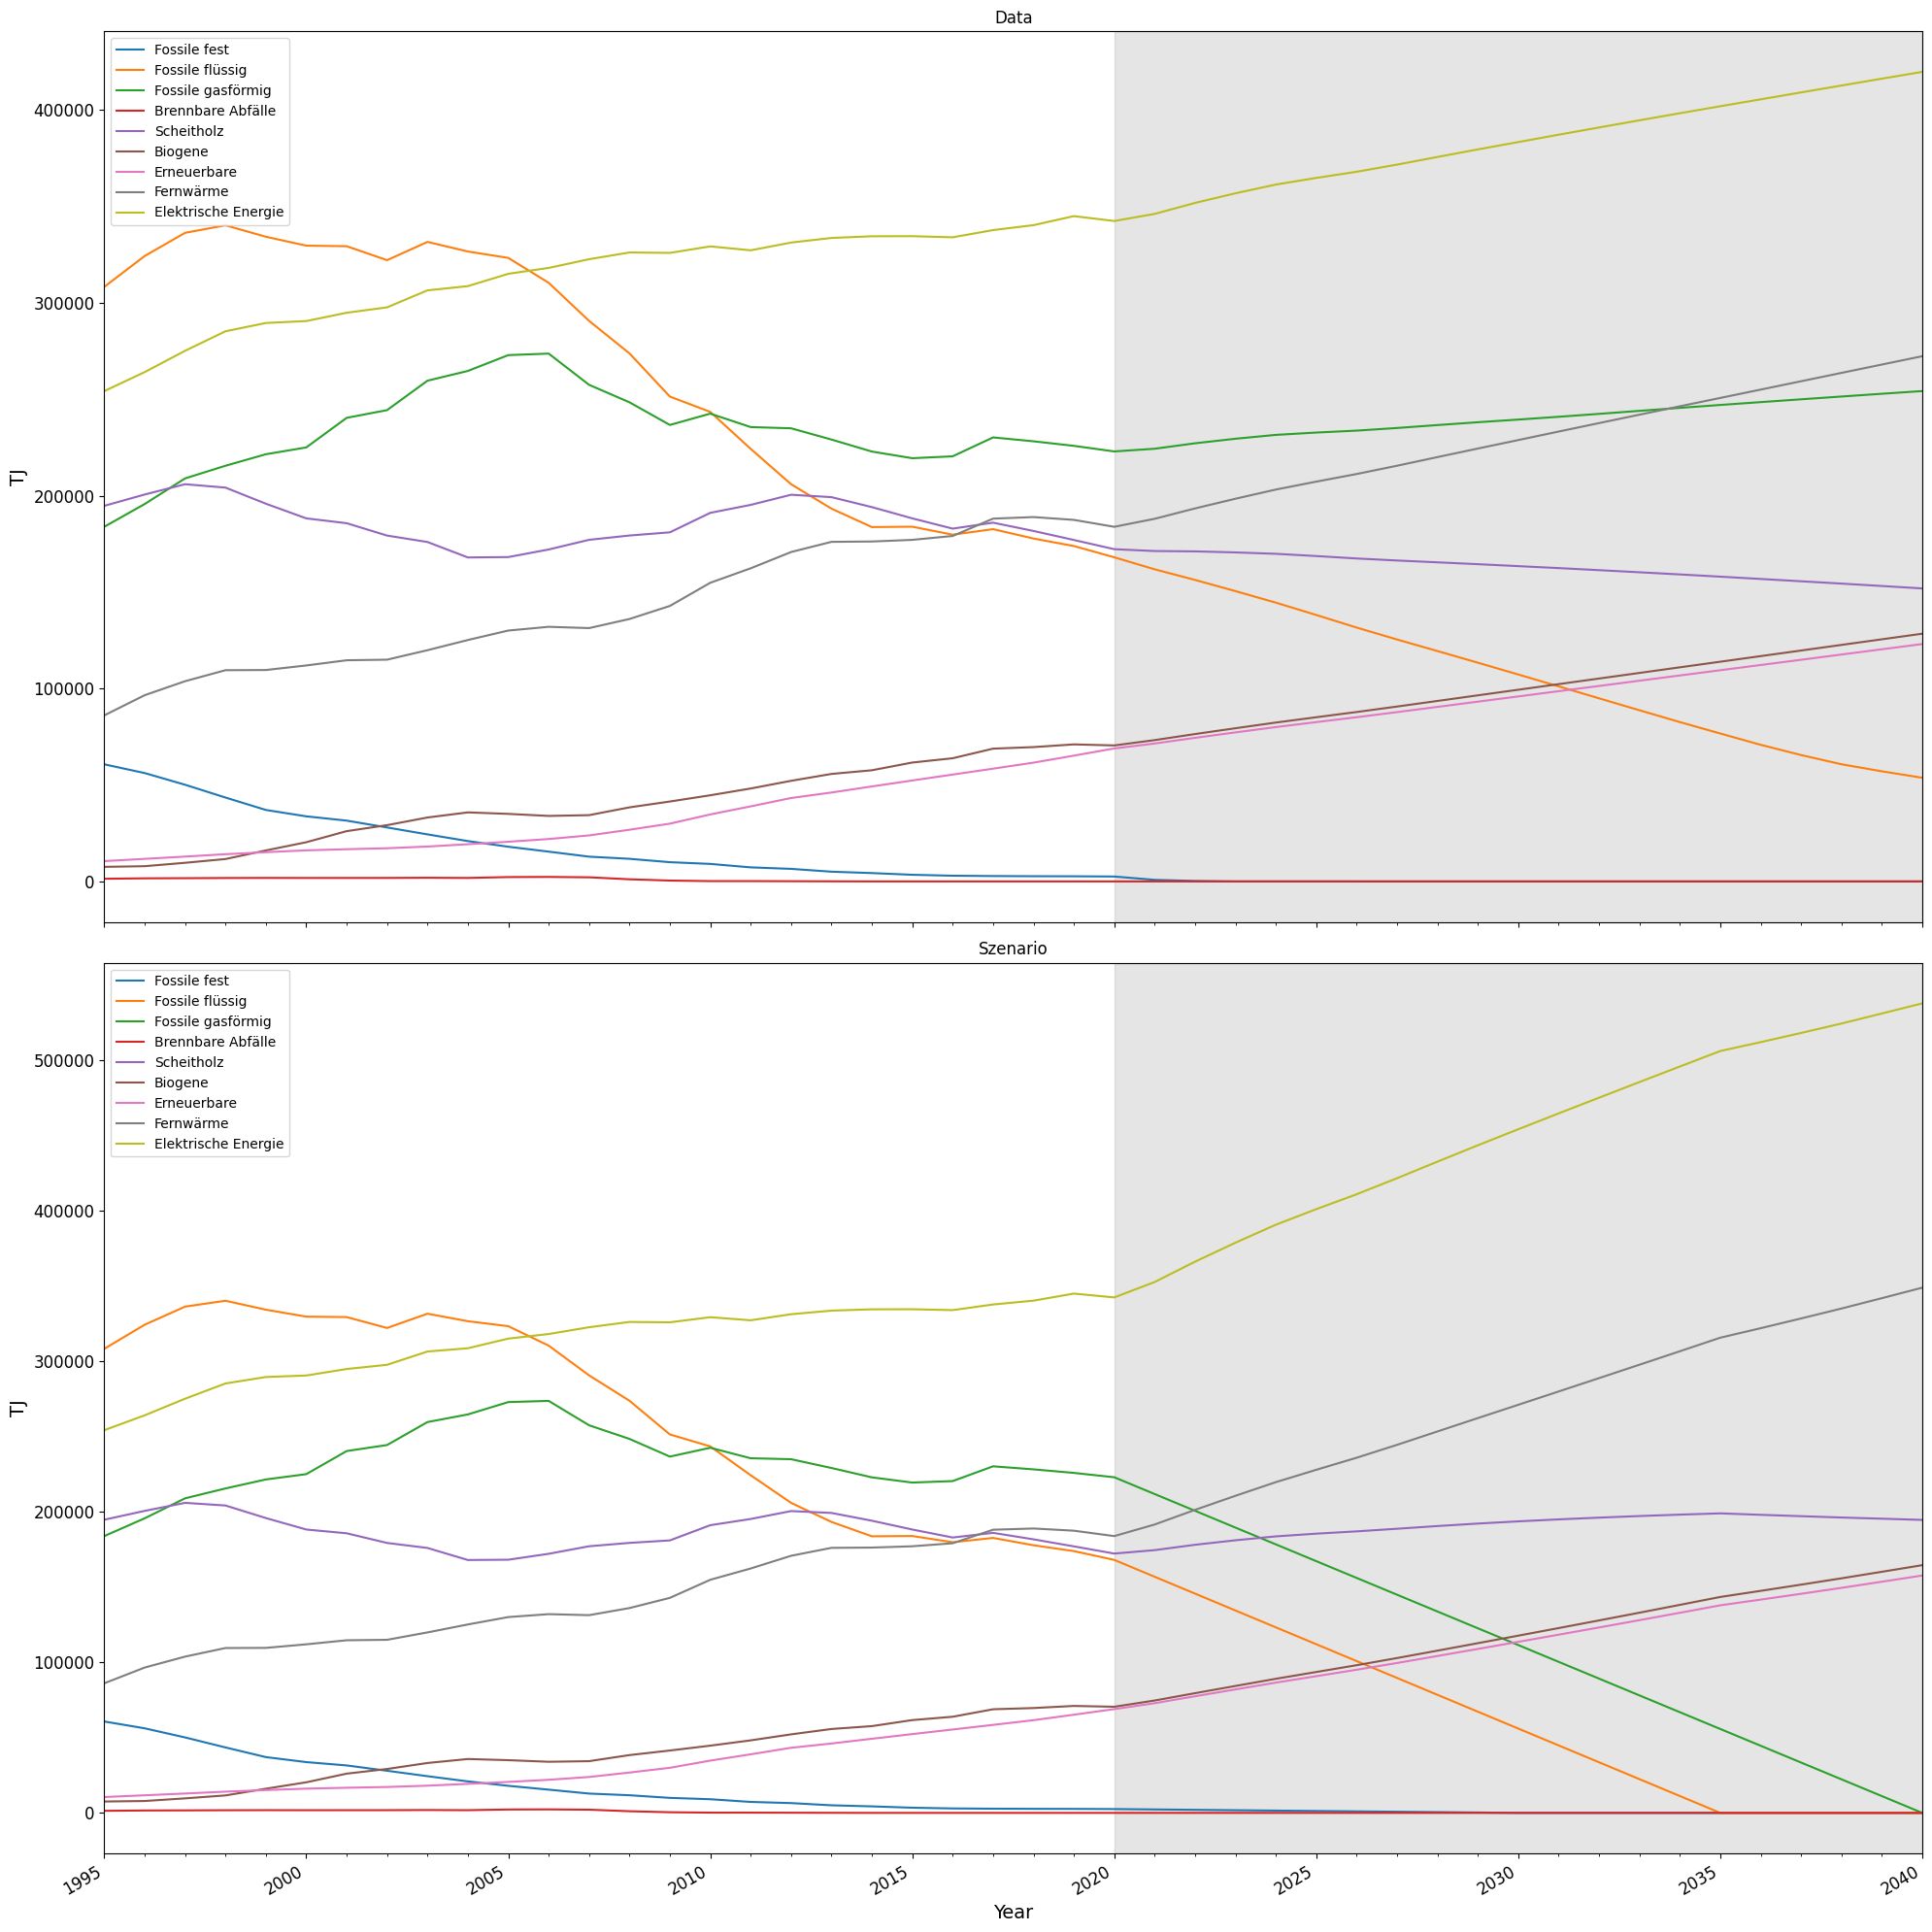

In [12]:
oesterreich = create_data_oesterreich()

test_scenario_oesterreich = create_test_scenario(oesterreich)
test_scenario_oesterreich_result = run_scenarios(oesterreich, test_scenario_oesterreich)

plot_result(oesterreich, test_scenario_oesterreich_result)

In [13]:

def create_limit_scenario(series: pd.Series, start: str, factor):
    et = series.name
    
    limit_series = series[start:end][1:]
    index = limit_series.index
    start_value = series[start]
    
    limit = pd.Series([start_value * factor^(i+1) for i in range(len(index))], index=index)
    
    
    decrement = start_value / (len(index))
    start_series = series[:start]
    wanted_series = pd.Series([start_value * factor^(i+1) for i in range(len(index))], index=index)
    end_series = series[end:][1:]
    result = pd.concat([start_series, wanted_series, end_series])
    result.name = series.name
    return result